# Linear Regression with Tensorflow

## Introduction
Linear Regression is the **_Hello World_** of Machine Learning. In this notebook we will implement a _simple linear regression (univariate linear regression)_, a model with one predictor and one response variable. The goal is to recap and practice fundamental concepts of Machine Learning. After the exercise, you should have a deeper understanding of what a Machine Learning model is and how do you train such a model with a data set (supervised learning). To achieve this, you will:

## Requirements
### Knowledge
You should have a basic knowledge of Machine Learning models, cost functions, optimization algorithms and also numpy and matplotlib. We will only recap these concepts for a better understanding and do not explain them in great detail. Suitable sources for acquiring this knowledge are:
- [Simple Linear Regression Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/univariate-linear-regression.php) by Christian Herta and his [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/linearRegression.pdf) (German)
- Chapter 2 of the open classroom [Machine Learning](http://openclassroom.stanford.edu/MainFolder/CoursePage.php?course=MachineLearning) by Andrew Ng
- Chapter 5.1 of [Deep Learning](http://www.deeplearningbook.org/contents/ml.html) by Ian Goodfellow 
- Some parts of chapter 1 and 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop
- [numpy quickstart](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [Matplotlib tutorials](https://matplotlib.org/tutorials/index.html)

### Python Modules

By [deep.TEACHING](https://www.deep-teaching.org/) convention, all python modules needed to run the notebook are loaded centrally at the beginning. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

### Create a Dataset
First of all, we generate a data set $\Omega$ so you can evaluate your implementation. $\Omega$ consists of tupels $(x^i,y^i)$. Let $x$ and $y$ be two numpy arrays of equal-length $m$. Create a linear function of $m$ data points in a given range $[x_{mi}, x_{max}]$. The $x$ values should be distributed equally over the defined interval. Add some Gaussian distributed noise to the corresponding $y$ values. Each response variable should differ from their ideal value by an additional $\delta$.

\begin{equation}
    f(x)= a + b * x + \sigma , \; with \ X=\left \{  x \in \mathbb{R} \mid x_{min} \leqslant x \leqslant  x_{max} \right \} 
\end{equation}

In [2]:
# fixed random seed for testing
np.random.seed(42)

def linear_random_data(sample_size, a, b, x_min, x_max, noise_factor):
    '''creates a randam data set based on a lienar function in a given interval

    Args:
        sample_size: number of data points
        a: coefficent of x^0
        b: coefficent of x^1
        x_min: lower bound value range
        x_max: upper bound value range
        noise_factor: strength of nosie added to y 

    Returns:
        x: array of x values | len(x)==len(y)
        y: array of y values corresponding to x | len(x)==len(y)
    '''
    x = np.random.uniform(x_min, x_max, sample_size)
    y = a + b * x + np.random.randn(len(x)) * noise_factor
    return x, y

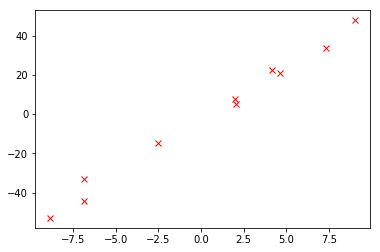

In [3]:
x, y = linear_random_data(10, 0., 5., -10, 10, 5)
plt.plot(x,y, "rx")

### Tensorflow Placeholder
So far we have used numpy arrays to manage our data, but in order to build a model in tensorflow we need another structure, the placeholder. A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data.

In [4]:
X_ = tf.placeholder(dtype=tf.float32)
Y_ = tf.placeholder(name="Y", dtype=tf.float32)

## Univariate Linear Regression
### Linear Hypothesis
A short recap, a hypothesis $h_\theta(x)$ is a certain function that we believe is similar to a target function that we like to model. A hypothesis $h_\theta(x)$ is a function of $x$ with fixed parameters $\theta$. The simplest kind of hypothesis is based on a linear equation with two parameters: 

\begin{equation}
    h_\theta(x) = \theta_{0} + \theta_{1} * x 
\end{equation}

Implement hypothesis $h_\theta(x)$ in the method `linear_hypothesis` and return it as a function. 

In [5]:
def linear_hypothesis(theta_0, theta_1):
    ''' Combines given arguments in a linear equation and returns it as a function
    
    Args:
        theta_0: first coefficient
        theta_1: second coefficient
        
    Returns:
        linear hypothesis as tensor and dependend on X_ (our placeholder for the input data)
    ''' 
    return theta_1 * X_ + theta_0

### Cost Function
A cost function $J$ depends on the given training data $D$ and hypothesis $h_\theta(x)$. In the context of the simple linear regression, the cost function measures how wrong a model is regarding its ability to estimate the relationship between $x$ and $y$ for specific $\theta$ values. Later we will treat this as an optimization problem and try to minimize the cost function $J_D(\theta)$ to find optimal $\theta$ values for our hypothesis $h_\theta(x)$. The cost function we use in this exercise is the [Mean-Squared-Error](https://en.wikipedia.org/wiki/Mean_squared_error) cost function:

\begin{equation}
    J_D(\theta)=\frac{1}{2m}\sum_{i=1}^{m}{(h_\theta(x_i)-y_i)^2}
\end{equation}

Implement the cost function $J_D(\theta)$ in the method `mse_cost_function`. The method should return a function that takes the values of $\theta_0$ and $\theta_1$ as an argument.

Sidenote, the terms loss function or error function are often used interchangeably in the field of Machine Learning.

In [6]:
def mse_cost_function(x, y, hypothesis):
    ''' Implements MSE cost function as a function J(theta_0, theta_1) on given tranings data 

    Args:
        x: vector of x values 
        y: vector of ground truth values y 
        hypothesis: a hypothesis tensor e.g. from linear_hypothesis
    Returns:
        lambda J(theta_0, theta_1) that models the cost function
    '''
    return tf.reduce_mean(tf.pow(hypothesis - Y_, 2))

###  Gradient Descent

A short recap, the gradient descent algorithm is a first-order iterative optimization for finding a minimum of a function. From the current position in a (cost) function, the algorithm steps proportional to the negative of the gradient and repeats this until it reaches a local or global minimum and determines. Stepping proportional means that it does not go entirely in the direction of the negative gradient, but scaled by a fixed value $\alpha$ also called the learning rate. Implementing the following formalized update rule is the core of the optimization process:

\begin{equation}
    \theta_{j_{new}} \leftarrow \theta_{j_{old}} - \alpha * \frac{\delta}{\delta\theta_{j_{old}}} J(\theta_{old})
\end{equation}

In [7]:
def update_theta(x, y, theta_0, theta_1, learning_rate, loss_function, sess):
    ''' Updates learnable parameters theta_0 and theta_1

    The update is done by calculating the partial derivities of
    the cost function including the linear hypothesis. The
    gradients scaled by a scalar are subtracted from the given
    theta values.

    Args:
        x: array of x values
        y: array of y values corresponding to x
        theta_0: current theta_0 value
        theta_1: current theta_1 value
        learning_rate: value to scale the negative gradient

    Returns:
        t0: Updated theta_0
        t1: Updated theta_1
    '''
    grad = tf.gradients(loss_function, [theta_0, theta_1])
    t_grad = sess.run(grad, feed_dict={X_: x, Y_: y})
    theta_0 = theta_0 - learning_rate * t_grad[0]
    theta_1 = theta_1 - learning_rate * t_grad[1]
    return theta_0, theta_1

Using the `update_theta` method, we can now implement the gradient descent algorithm. Iterate over the update rule to find a $\theta_0$ and a $\theta_1$ that minimize our cost function $J_D(\theta)$. This process is often called training of a machine learning model. During the training process create a history of all theta and cost values. We can use them later for evaluation. Implement a `verbose` argument that if true provides additional information during the process, e.g., final theta values after optimization or cost value at some iterations.

In [8]:
def gradient_descent(x, y, t0, t1, iterations=1000, learning_rate=0.0001):
    ''' Minimize theta values of a linear model based on MSE cost function

    Args:
        x: vector, x values from the data set
        y: vector, y values from the data set
        iterations: scalar, number of theta updates
        learning_rate: scalar, scales the negative gradient 
        verbose: boolean, print addition information 

    Returns:
        t0: Updated theta_0
        t1: Updated theta_1
    '''
    loss_history = []
    # session
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    # gradient descent
    for i in tqdm(range(iterations)):
        # defining our forward path/loss function
        mse = mse_cost_function(x, y, linear_hypothesis(t0, t1))
        # one training step - updating theta
        t0, t1 = update_theta(x, y, t0, t1, learning_rate, mse, sess)
        # calculating loss and appending in to our list
        loss = sess.run(mse, feed_dict={X_: x, Y_: y})
        loss_history.append(loss)
    return [t0, t1], loss_history, sess

In [9]:
t0 = tf.Variable(5, dtype=tf.float32)
t1 = tf.Variable(-1, dtype=tf.float32)

In [10]:
opt_thetas, loss_history, sess = gradient_descent(x, y, t0, t1, iterations=100, learning_rate=0.01)

100%|██████████| 100/100 [00:23<00:00,  2.41it/s]


###  Model and Training Evaluation
Now visualize the training process by plotting the `cost_hist` as a curve. Also, create a plot that shows the decision boundary of your final hypothesis (model) inside your data. Your plots should look like:

In [11]:
def evaluation_plt(loss_history, opt_thetas, x, y, sess):
    ''' Plots a cost curve and the decision boundary

    The Method plots a cost curve from a given training process (cost_hist). 
    It also plots the data set (x,y) and draws a linear decision boundary 
    with the parameters theta_0 and theta_1 into the plotted data set.

    Args:
        cost_hist: vector, history of all cost values from a opitmization
        theta_0: scalar, model parameter for boundary
        theta_1: scalar, model parameter for boundary
        x: vector, x values from the data set
        y: vector, y values from the data set
    '''
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(loss_history)
    ax1.set_title('loss history')

    t0, t1 = sess.run(opt_thetas)
    ax2.plot(x, y, "rx")
    ax2.plot(x, t0 + t1 * x)

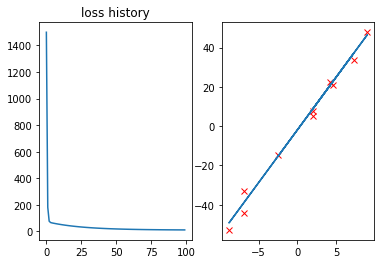

In [12]:
evaluation_plt(loss_history, opt_thetas, x, y, sess)

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Simple Linear Regression <br/>
by Christian Herta, Benjamin Voigt <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Benjamin Voigt

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.